In [2]:
import numpy as np
import numpy.random as random
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from dataset import TreeStimuli, Neuron, Ensemble,NoisyEnsemble, LinearNeuron, InteractionNeuron,LogisticNeuron, UnivariateGaussianNeuron, MultivariateGaussianNeuron
from copy import deepcopy
from functools import partial
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from utils import compute_rdm,scale_feature,lower_tri

# Synthetic dataset generation

## stimuli space

First we generate a set of tree stimuli of varying leafiness and branchiness. Here we didn't specify the feature vector of leafiness and branchiness, and it will by default create 40 stimuli from factorial combinations of 20 levels of leafiness and 2 levels of branchiness

In [3]:
Trees = TreeStimuli(leafiness   = np.linspace(0.2,1,2,False), branchiness = np.linspace(0.2,1,10,False))
Trees.stimuli.shape

(40, 2)

## Define different types of neurons and ensembles

One instantiation of the various `**Neuron` class create a neuron with parameterized firing function. Linear/nonlinear pure/mixed selectivity can be achieved by different class and different parameters (see documentation for further details). 

c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

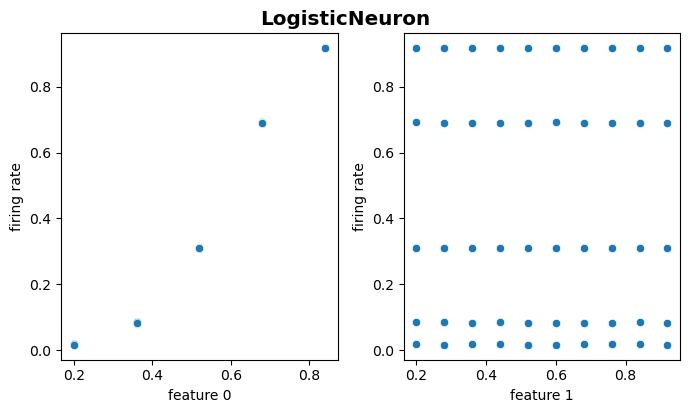

In [3]:
logisiticneuron_param = {"w":np.array([[1],[0]]), "k":10, "x0":0.6}
_ = LogisticNeuron(**logisiticneuron_param).plot_firingrate(Trees.stimuli)

Alternatively, new neuron class can be created as needed.

c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

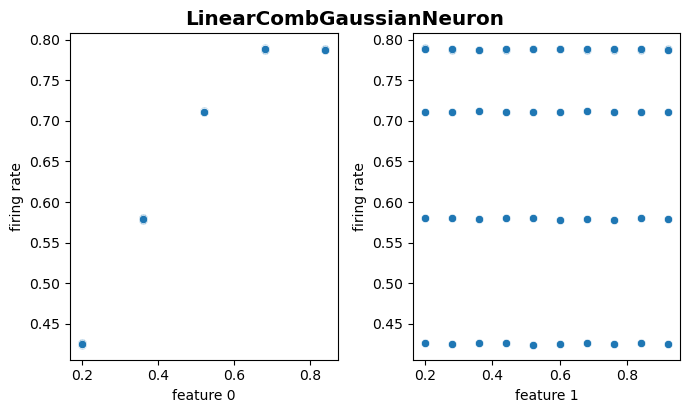

In [4]:
class LinearCombGaussianNeuron(Neuron):
  def __init__(self,w,mus,sigs,noise_mu:int=0,noise_sig:int=0.001) -> None:
    super().__init__(noise_mu,noise_sig)
    gaussians = [partial(lambda x: scipy.stats.norm(mu,sig).pdf(x)) for (mu,sig) in zip([0.33,0.76],[.22,.5])]
    self.activate = lambda stimuli: np.array([gaussian(stimuli[:,j]) for j,gaussian in enumerate(gaussians)]).T@w
    self.firing_description = f"feature weights = {w} \nmultivariate gaussian centered around {mus},\n sigma={sigs} \n"

class LinearCombLogisticNeuron(Neuron):
  def __init__(self,w,ks,x0s,noise_mu=0,noise_sig=1) -> None:
    super().__init__(noise_mu,noise_sig)
    sigmoids = [partial(lambda x: 1/(1+np.exp(-k*(x-x0))))for (k,x0) in enumerate(zip(ks,x0s))]
    self.activate = lambda stimuli: np.array([sigmoid(stimuli[:,j]) for j,sigmoid in enumerate(sigmoids)])@w
    self.firing_description = f"feature weights = {w} \n logistic function k={ks},\n x0={x0s} \n"

lcgauneuron_param = {"w":np.array([[1],[0]]), "mus":[0.33,0.76], "sigs":[0.2,0.5]}
_ = LinearCombGaussianNeuron(**lcgauneuron_param).plot_firingrate(Trees.stimuli)

An ensemble consists of multiple neurons, each with different firing functions. Here we set up different ensembles with either linear/nonlinear pure/mixed selectivity. Each has two neurons, and we can visualize the firing space in 2D and compare with the 2D Tree stimuli space

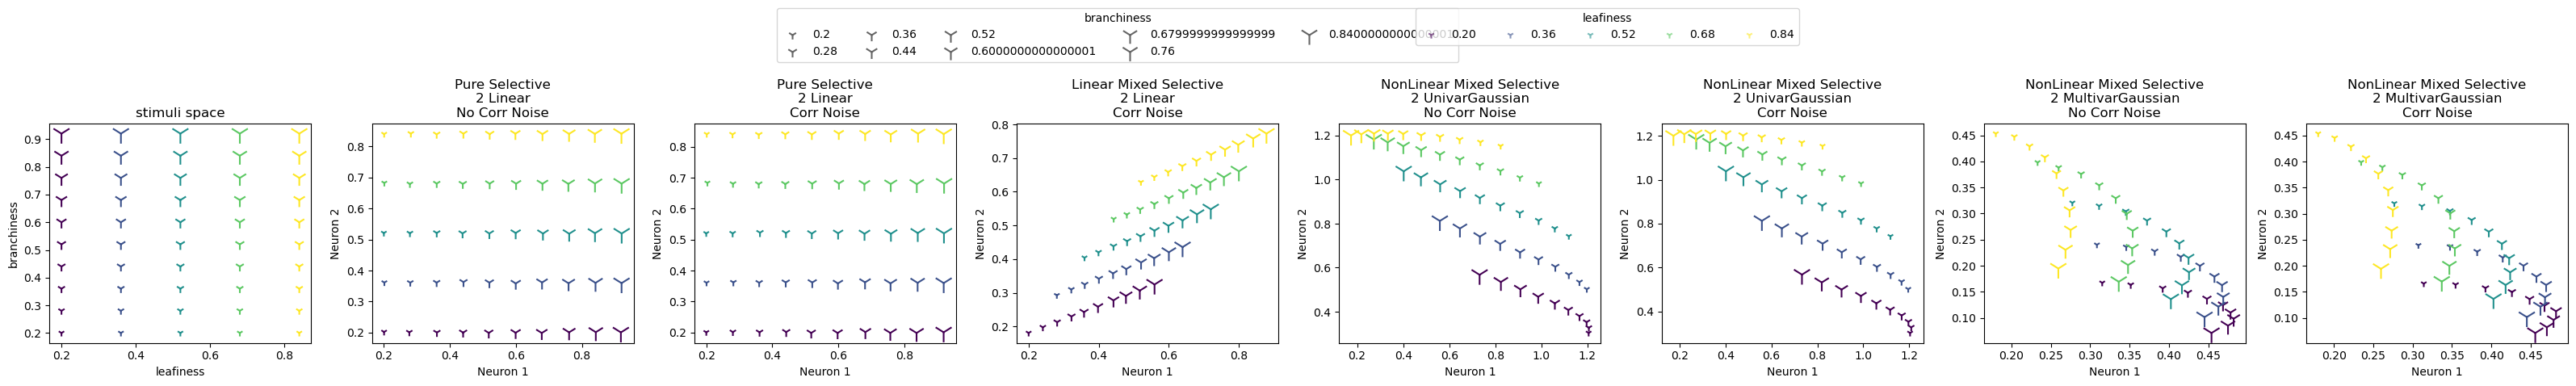

In [5]:
## Ensemble 1:  2 pure selective - linear+linear no correlated noise
classes = [LinearNeuron,LinearNeuron]
params = [{"w":np.array([[0],[1]])},
          {"w":np.array([[1],[0]])}]
PureSelectiveMixEnsemble = NoisyEnsemble(classes,params)
#PureSelectiveMixEnsemble.fire(Trees.stimuli)

## Ensemble 2:  2 pure selective - linear+linear correlated noise
PureSelectiveMixEnsembleCN = NoisyEnsemble(classes,params,corr=0.8)
PureSelectiveMixEnsembleCN.fire(Trees.stimuli)

## Ensemble 3:  2 mixed selective - linear+linear correlated noise
params = [{"w":np.array([[0.5],[0.5]])},
          {"w":np.array([[0.7],[0.2]])}]
MixSelectiveLinearEnsembleCN = NoisyEnsemble(classes,params,corr=0.8)
MixSelectiveLinearEnsembleCN.fire(Trees.stimuli)

## Ensemble 4:  2 mixed selective - univariate gaussian no correlated noise
classes = [UnivariateGaussianNeuron,UnivariateGaussianNeuron]
params = [{"w":np.array([[0.5],[0.5]]),
           "mu":0.23,
           "sig":0.33},
          {"w":np.array([[0.7],[0.2]]),
           "mu":0.73,
           "sig":0.33}]
MixSelectiveUGaussianEnsemble = NoisyEnsemble(classes,params)
MixSelectiveUGaussianEnsemble.fire(Trees.stimuli)

## Ensemble 5:  2 mixed selective - univariate gaussian correlated noise
MixSelectiveUGaussianEnsembleCN = NoisyEnsemble(classes,params,corr=0.8)
MixSelectiveUGaussianEnsembleCN.fire(Trees.stimuli)

## Ensemble 6:  2 mixed selective - multivariate gaussian no correlated noise
classes = [MultivariateGaussianNeuron,MultivariateGaussianNeuron]
params = [{"mus":[0.23,0.73],
           "cov":0.33},
          {"mus":[1.04,0.17],
           "cov":0.33}]
MixSelectiveMGaussianEnsemble = NoisyEnsemble(classes,params)
MixSelectiveMGaussianEnsemble.fire(Trees.stimuli)

## Ensemble 7:  2 mixed selective - multivariate gaussian correlated noise
MixSelectiveMGaussianEnsembleCN = NoisyEnsemble(classes,params,corr=0.8)
MixSelectiveMGaussianEnsembleCN.fire(Trees.stimuli)

TwoNeuronSpaces = {
    "stimuli space":Trees.stimuli,
    "Pure Selective - 2 Linear - No Corr Noise":PureSelectiveMixEnsemble.fire(Trees.stimuli),
    "Pure Selective - 2 Linear - Corr Noise":PureSelectiveMixEnsembleCN.fire(Trees.stimuli),
    "Linear Mixed Selective - 2 Linear - Corr Noise": MixSelectiveLinearEnsembleCN.fire(Trees.stimuli),
    "NonLinear Mixed Selective - 2 UnivarGaussian - No Corr Noise": MixSelectiveUGaussianEnsemble.fire(Trees.stimuli),
    "NonLinear Mixed Selective - 2 UnivarGaussian - Corr Noise": MixSelectiveUGaussianEnsembleCN.fire(Trees.stimuli),
    "NonLinear Mixed Selective - 2 MultivarGaussian - No Corr Noise": MixSelectiveMGaussianEnsemble.fire(Trees.stimuli),
    "NonLinear Mixed Selective - 2 MultivarGaussian - Corr Noise": MixSelectiveMGaussianEnsembleCN.fire(Trees.stimuli),
    }

fig_fspace,ax_fspace = plt.subplots(1,len(TwoNeuronSpaces),figsize=(4*(len(TwoNeuronSpaces)),4))
for js,(s_name,s_mat) in enumerate(TwoNeuronSpaces.items()):
    splot=ax_fspace[js].scatter(x=s_mat[:,0],y=s_mat[:,1],c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax_fspace[js].set_title(s_name.replace(' - ','\n'))
    if "stimuli" in s_name:
        ax_fspace[js].set_xlabel(Trees.featurenames[0])
        ax_fspace[js].set_ylabel(Trees.featurenames[1])
    else:
        ax_fspace[js].set_xlabel("Neuron 1")
        ax_fspace[js].set_ylabel("Neuron 2")
hs, ls = splot.legend_elements(prop="sizes", alpha=0.6)
ls = np.unique(Trees.stimuli[:,1])#use original feature value as label
hc, lc = splot.legend_elements(prop="colors", alpha=0.6)
fig_fspace.legend(hs,ls, loc='outside upper left',bbox_to_anchor=(0.3,1.2),ncol=5, title=Trees.featurenames[1])
fig_fspace.legend(hc,lc, loc='outside upper right',bbox_to_anchor=(0.7,1.2),ncol=5, title=Trees.featurenames[0])
fig_fspace.tight_layout()

In [6]:
noise = PureSelectiveMixEnsembleCN.noise(Trees.stimuli.shape[0])
plt.scatter(noise[:,0],noise[:,1])
scipy.stats.pearsonr(noise[:,0],noise[:,1])

TypeError: <lambda>() missing 1 required positional argument: 'rng'

contour plots can help visualize the firing landscape of the neurons

In [ ]:
stim_space = deepcopy(Trees.stimuli)
new_shape=tuple([np.size(x) for x in Trees.features])
F1, F2 = np.reshape(stim_space[:,0],new_shape),np.reshape(stim_space[:,1],new_shape)
for js,(s_name,s_mat) in enumerate(TwoNeuronSpaces.items()):
    if s_name != "stimuli space":
        firing_space = s_mat
        fig, ax = plt.subplots(2,2,figsize=(8,7))
        for j in range(firing_space.shape[1]):
            H = np.reshape(firing_space[:,j],new_shape)
            cs=ax[j,0].contour(F1, F2, H)
            ax[j,0].clabel(cs, inline=True, fontsize=10)
            sc=ax[j,1].scatter(x=stim_space[:,0],y=stim_space[:,1],c=firing_space[:,j],cmap="hot")
            cbar = fig.colorbar(sc)
            cbar.set_label(f"Firing Rate of neuron {j+1}", loc='top')#
            ax[j,0].set_xlabel("leafiness")
            ax[j,1].set_xlabel("leafiness")
            ax[j,0].set_ylabel("branchiness")
            ax[j,1].set_ylabel("branchiness")
        fig.tight_layout()
        fig.suptitle(s_name,fontweight="bold",fontsize="x-large",position=(0.5,1.05))

explore PCA on different neuron ensembles

In [ ]:
from sklearn.decomposition import PCA
from utils import compute_rdm
pca_sapce = {}
for js,(s_name,s_mat) in enumerate(TwoNeuronSpaces.items()):
    pca_sapce |= {s_name:PCA(n_components=2).fit_transform(s_mat)}

plt_rows,plt_cols = 3,len(TwoNeuronSpaces)
fig_fspace,ax_fspace = plt.subplots(plt_rows,plt_cols,figsize=(3.1*plt_cols,3.3*plt_rows))
for js,(s_name,s_mat) in enumerate(TwoNeuronSpaces.items()):
    ax_fspace[0,js].scatter(x=s_mat[:,0],y=s_mat[:,1],c=stim_space[:,0],s=np.exp(stim_space[:,1]*3+3),marker="1")
    ax_fspace[0,js].set_title(s_name.replace(' - ','\n'))
    sns.heatmap(compute_rdm(s_mat,"euclidean"),ax=ax_fspace[1,js])
    ax_fspace[1,js].set_title('RDM of '+s_name.replace(' - ','\n'))
    ax_fspace[2,js].scatter(x=pca_sapce[s_name][:,0],y=pca_sapce[s_name][:,1],c=stim_space[:,0],s=np.exp(stim_space[:,1]*3+3),marker="1")
    ax_fspace[2,js].set_title('pca of '+s_name.replace(' - ','\n'))
    if "stimuli" in s_name:
        ax_fspace[0,js].set_xlabel(Trees.featurenames[0])
        ax_fspace[0,js].set_ylabel(Trees.featurenames[1])
    else:
        ax_fspace[0,js].set_xlabel("Neuron 1")
        ax_fspace[0,js].set_ylabel("Neuron 2")
    ax_fspace[2,js].set_xlabel("PC 1")
    ax_fspace[2,js].set_ylabel("PC 2")
fig_fspace.tight_layout()

## Define an ensemble with more than two neurons that will be used for geometry analysis

In [11]:
max_x,min_x = np.max(Trees.stimuli), np.min(Trees.stimuli)
r = (max_x-min_x)
mu_k = 1/r
seed=42
rng = np.random.default_rng(seed)
def GeneratePureSelectiveWeights(rng):
    weights = [[rng.uniform(0,1)],[0]]
    random.shuffle(weights)
    return(np.array(weights))

def GenerateMixedSelectiveWeights(rng):
    weights = [[rng.uniform(0,1)],[rng.uniform(0,1)]]
    return(np.array(weights))

# define parameter limits
sig_range = [0.01,0.9]
mu_range = [0.2,0.7]
cov_range = [0.0,0.9]
noise_mu, noise_sig = 0,0.1 # low noise
# hight noise: noise_mu, noise_sig = 0,0.1


In [12]:
# Number of neurons
N = 200

# correlation between noise in ensemble
noise_corr= 0.2

## Ensemble 1:  Pure Selective Linear 
classes = [LinearNeuron]*N
params = [{'w': GeneratePureSelectiveWeights(rng),
           'noise_mu':noise_mu,
           'noise_sig':noise_sig} for _ in range(N)]
PureSelectiveLinearEnsemble = NoisyEnsemble(classes,params,corr=noise_corr)

## Ensemble 2:  Pure Selective Non Linear (Univariate Gaussian)
classes = [UnivariateGaussianNeuron]*N
params = [{"w": GeneratePureSelectiveWeights(rng), 
           'mu':random.uniform(mu_range[0], mu_range[1]), 
           'sig':random.uniform(sig_range[0],sig_range[1]),
           'noise_mu':noise_mu,
           'noise_sig':noise_sig} for _ in range(N)]
PureSelectiveGaussianEnsemble = NoisyEnsemble(classes,params,corr=noise_corr)

## Ensemble 3:  Linear Mixed selective
classes = [LinearNeuron]*N
params = [{"w": GenerateMixedSelectiveWeights(rng),
           'noise_mu':noise_mu,
           'noise_sig':noise_sig} for _ in range(N)]
MixSelectiveLinearEnsemble = NoisyEnsemble(classes,params,corr=noise_corr)

## Ensemble 4:  Non Linear Mixed selective
classes = [MultivariateGaussianNeuron]*N
params = [{"mus":[random.uniform(mu_range[0], mu_range[1]),random.uniform(mu_range[0], mu_range[1])],
           "cov":1,#random.uniform(cov_range[0],cov_range[1]),
           'noise_mu':noise_mu,
           'noise_sig':noise_sig} for _ in range(N)]
MixSelectiveGaussianEnsemble = NoisyEnsemble(classes,params,corr=noise_corr)

## Ensemble 5:  None responsive Linear 
classes = [LinearNeuron]*N
params = [{'w': np.zeros((2,1)),
           'noise_mu':noise_mu,
           'noise_sig':noise_sig} for _ in range(N)]
NonRespLinearEnsemble = NoisyEnsemble(classes,params,corr=noise_corr)

NeuronSpaces = {
    "Stimuli Space":Trees.stimuli,
    "Pure Selective - Linear": PureSelectiveLinearEnsemble.fire(Trees.stimuli),       # ?factorized representation
    "Mixed Selective - Linear": MixSelectiveLinearEnsemble.fire(Trees.stimuli),       # ?factorized representations
    "Pure Selective - Non linear": PureSelectiveGaussianEnsemble.fire(Trees.stimuli), # ?factorized representation
    "Mixed Selective - Non Linear": MixSelectiveGaussianEnsemble.fire(Trees.stimuli), # ?non factorized representation?
    "Non-responsive - Linear": NonRespLinearEnsemble.fire(Trees.stimuli)              # no representation
}
stim_space = Trees.stimuli

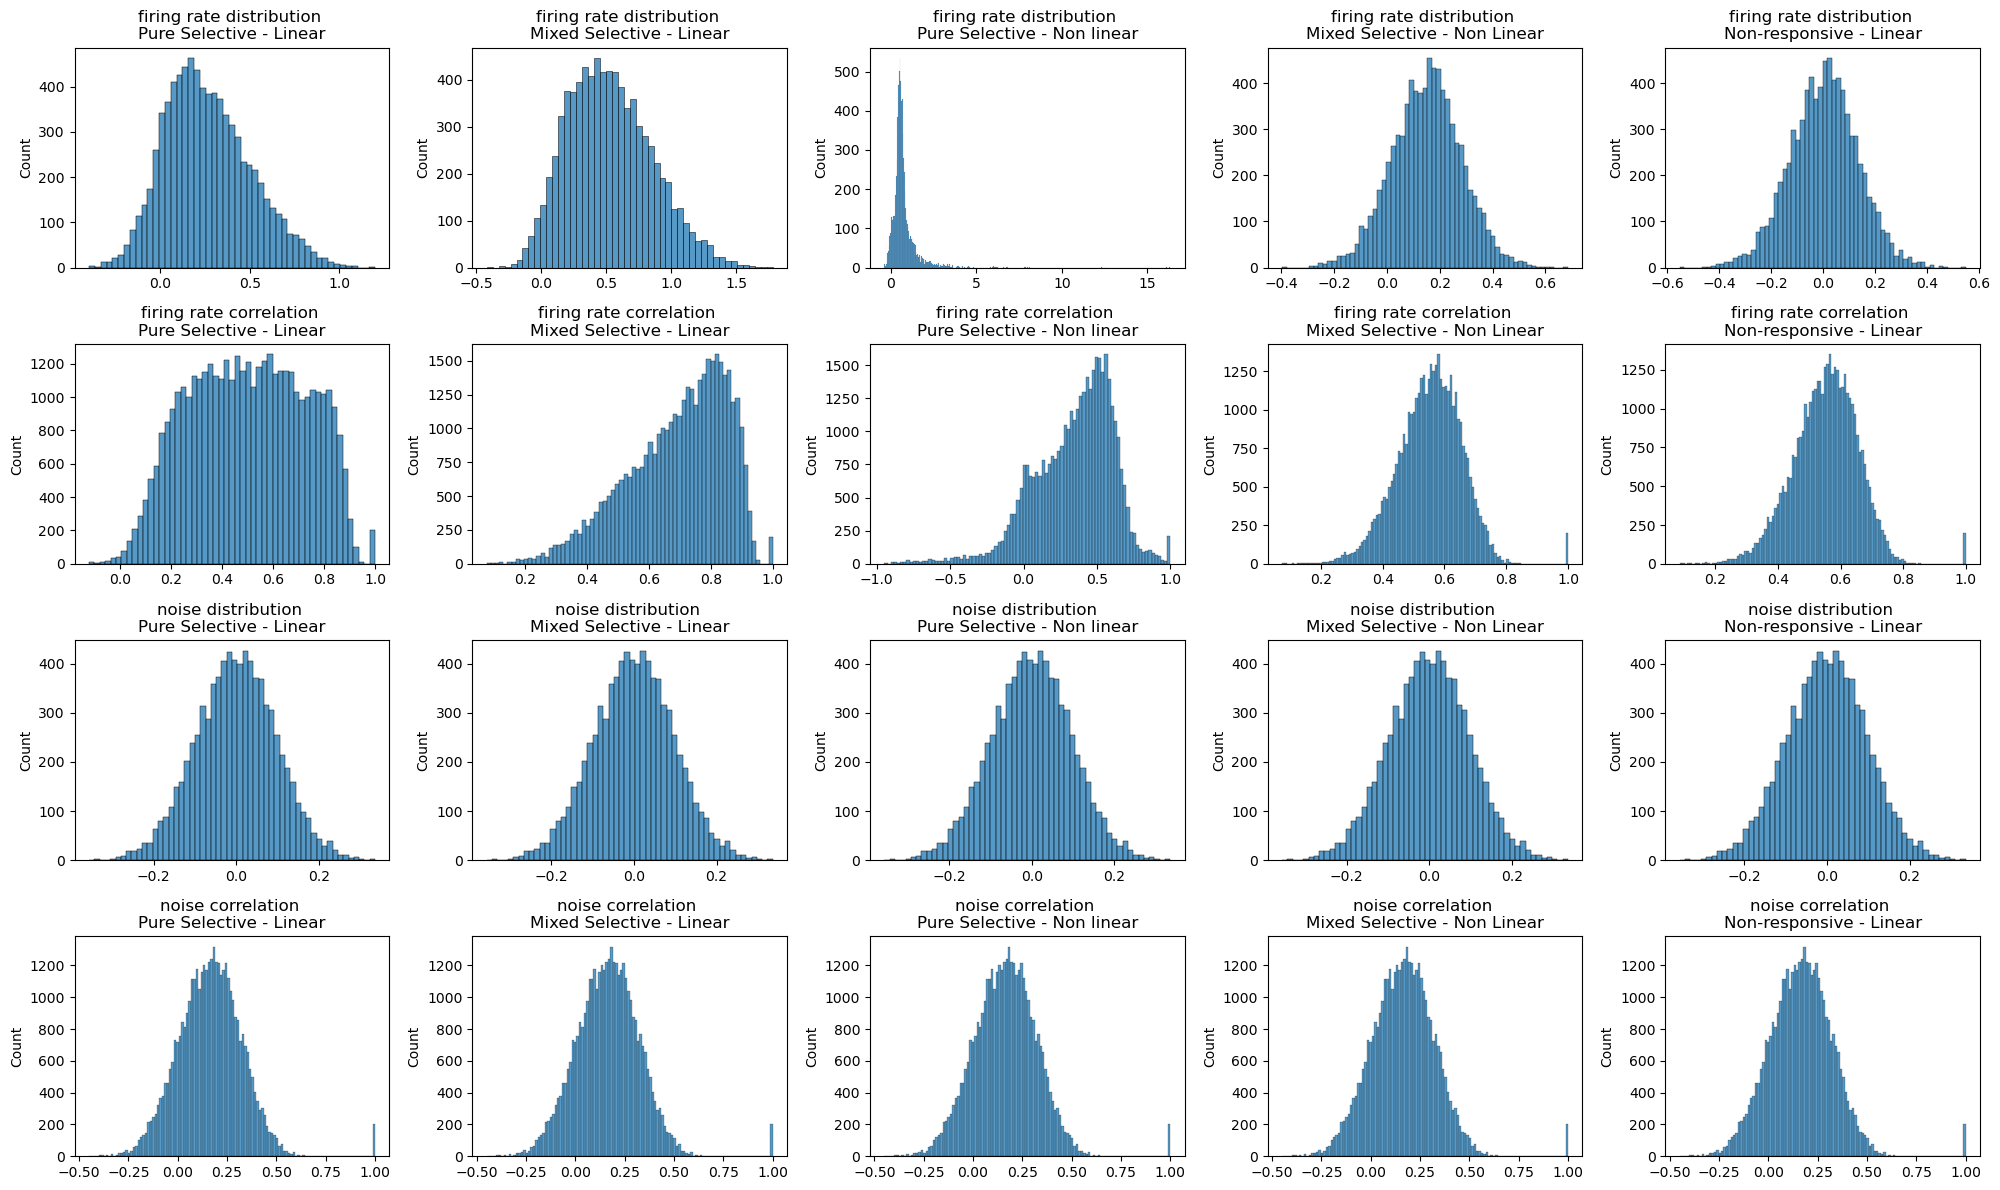

In [13]:
FiringEnsembles = {
    "Pure Selective - Linear": PureSelectiveLinearEnsemble,
    "Mixed Selective - Linear": MixSelectiveLinearEnsemble,
    "Pure Selective - Non linear": PureSelectiveGaussianEnsemble,
    "Mixed Selective - Non Linear": MixSelectiveGaussianEnsemble,
    "Non-responsive - Linear": NonRespLinearEnsemble
}
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "seaborn\..*" )

fig_frate,axes_frate = plt.subplots(4,len(FiringEnsembles),figsize=(len(FiringEnsembles)*4,4*3))
for j,(k,v) in enumerate(FiringEnsembles.items()):
    axes_frate[0,j].set_title("firing rate distribution \n" + k)
    axes_frate[1,j].set_title("firing rate correlation \n" + k)
    axes_frate[2,j].set_title("noise distribution \n" + k)
    axes_frate[3,j].set_title("noise correlation \n" + k)
    f_data = v.fire(Trees.stimuli)
    n_data = v.noise(Trees.stimuli.shape[0],np.random.default_rng(21))
    sns.histplot(f_data.flatten(),ax=axes_frate[0,j])
    sns.histplot(1-compute_rdm(f_data.T,"correlation").flatten(),ax=axes_frate[1,j])
    sns.histplot(n_data.flatten(),ax=axes_frate[2,j])
    sns.histplot(1-compute_rdm(n_data.T,"correlation").flatten(),ax=axes_frate[3,j])
    #sns.heatmap(v.noise_cov,ax=axes_frate[4,j],robust=True)

fig_frate.tight_layout()

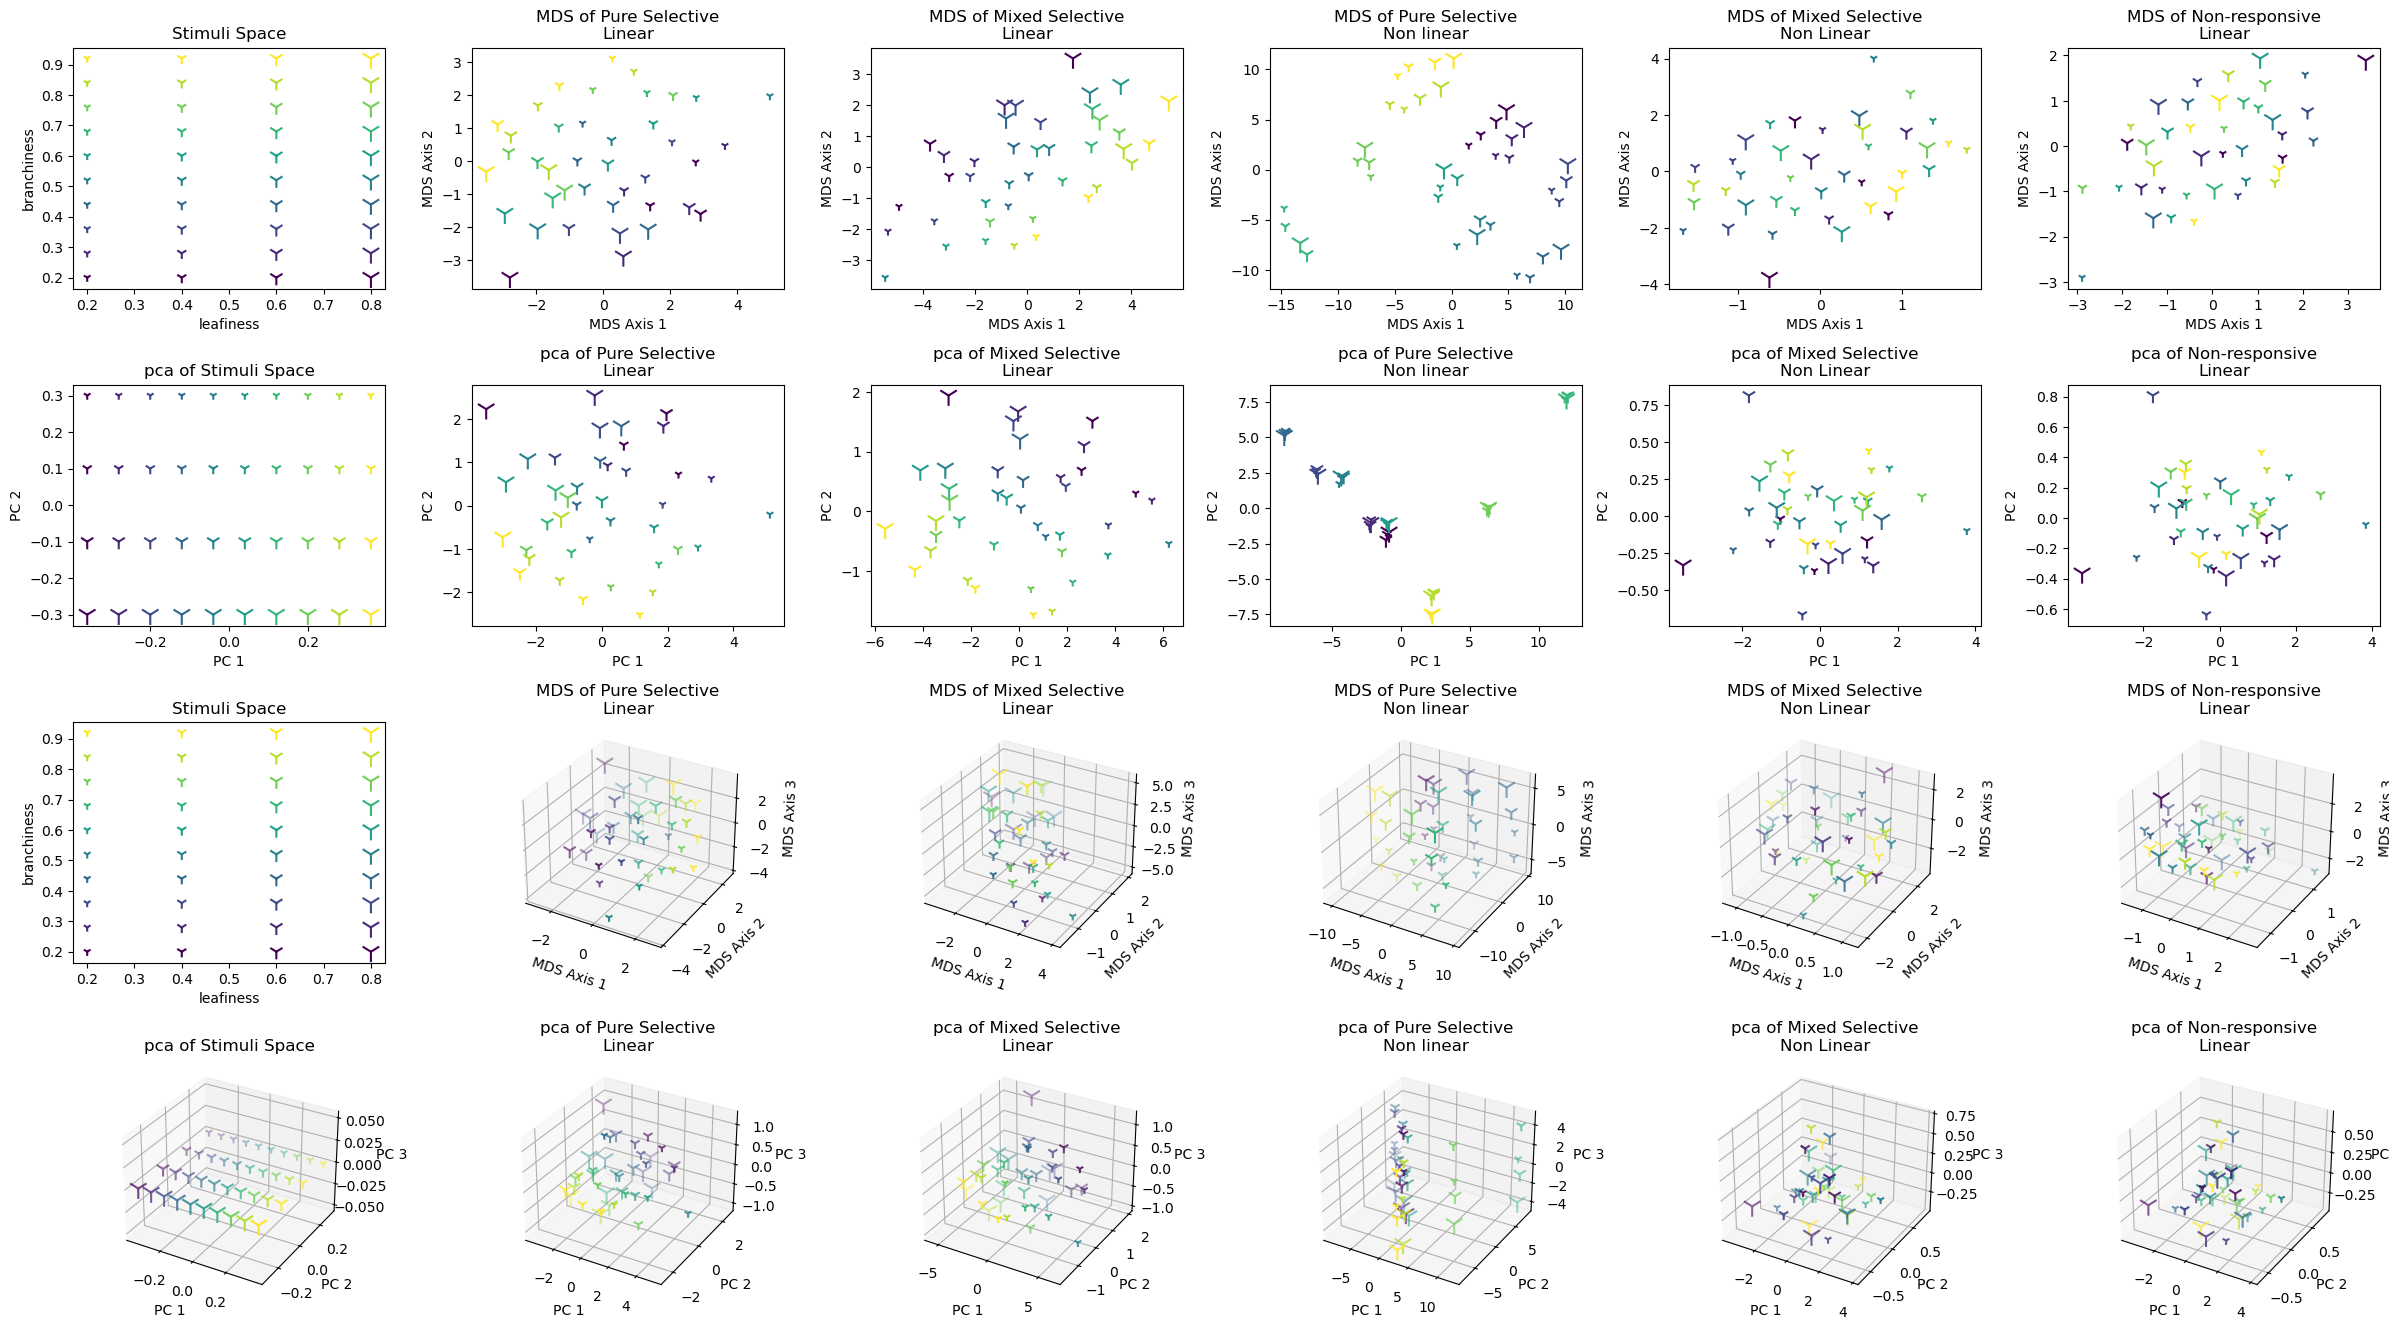

In [14]:
plt_rows,plt_cols = 4,len(NeuronSpaces)
fig_fspace,ax_fspace = plt.subplots(plt_rows,plt_cols,
                                    figsize=(4*plt_cols,3.3*plt_rows))
for kc,n_compo in enumerate([2,3]):
    pca_sapce,mds_space = {},{}
    for js,(s_name,s_mat) in enumerate(NeuronSpaces.items()):
        if "Stimuli" in s_name and n_compo==3:
            pca_sapce |= {s_name:np.concatenate([PCA(n_components=2).fit_transform(s_mat),np.zeros((Trees.stimuli.shape[0],1))],axis=1)}
            mds_res = MDS(n_components=2,normalized_stress="auto",dissimilarity="precomputed").fit_transform(compute_rdm(s_mat,"euclidean"))
            mds_space |= {s_name:np.concatenate([mds_res,np.zeros((Trees.stimuli.shape[0],1))],axis=1)}        
        else:
            pca_sapce |= {s_name:PCA(n_components=n_compo).fit_transform(s_mat)}
            mds_res = MDS(n_components=n_compo,normalized_stress="auto",dissimilarity="precomputed").fit_transform(compute_rdm(s_mat,"euclidean"))
            mds_space |= {s_name:mds_res}

    for js,((s_name,s_mat),pca_res,mds_res) in enumerate(zip(NeuronSpaces.items(),pca_sapce.values(),mds_space.values())):
        if "Stimuli" in s_name:
            ax_fspace[0+kc*2,js].scatter(x=s_mat[:,0],y=s_mat[:,1],c=stim_space[:,1],s=np.exp(stim_space[:,0]*3+3),marker="1")
            ax_fspace[0+kc*2,js].set_title(s_name.replace(' - ','\n'))
            ax_fspace[0+kc*2,js].set_xlabel(Trees.featurenames[0])
            ax_fspace[0+kc*2,js].set_ylabel(Trees.featurenames[1])
        else:
            if n_compo == 3:
                ax_fspace[0+kc*2,js].remove()
                p_num = (0+kc*2)*plt_cols+js
                ax_fspace[0+kc*2,js]=fig_fspace.add_subplot(plt_rows,plt_cols,p_num+1,projection='3d')
                ax_fspace[0+kc*2,js].scatter(mds_res[:,0],mds_res[:,1],mds_res[:,2],c=stim_space[:,1],s=np.exp(stim_space[:,0]*3+3),marker="1")   
                ax_fspace[0+kc*2,js].set_zlabel("MDS Axis 3")         
            else:
                ax_fspace[0+kc*2,js].scatter(mds_res[:,0],mds_res[:,1],c=stim_space[:,1],s=np.exp(stim_space[:,0]*3+3),marker="1")
            ax_fspace[0+kc*2,js].set_title('MDS of '+s_name.replace(' - ','\n'))
            ax_fspace[0+kc*2,js].set_xlabel("MDS Axis 1")
            ax_fspace[0+kc*2,js].set_ylabel("MDS Axis 2")
        
        if n_compo == 3:
            ax_fspace[1+kc*2,js].remove()
            p_num = (1+kc*2)*plt_cols+js
            ax_fspace[1+kc*2,js]=fig_fspace.add_subplot(plt_rows,plt_cols,p_num+1,projection='3d')
            ax_fspace[1+kc*2,js].scatter(pca_res[:,0],pca_res[:,1],pca_res[:,2],c=stim_space[:,1],s=np.exp(stim_space[:,0]*3+3),marker="1")
            ax_fspace[1+kc*2,js].set_zlabel("PC 3")
        else:
            ax_fspace[1+kc*2,js].scatter(x=pca_res[:,0],y=pca_res[:,1],c=stim_space[:,1],s=np.exp(stim_space[:,0]*3+3),marker="1")
        ax_fspace[1+kc*2,js].set_title('pca of '+s_name.replace(' - ','\n'))
        ax_fspace[1+kc*2,js].set_xlabel("PC 1")
        ax_fspace[1+kc*2,js].set_ylabel("PC 2")
    
fig_fspace.tight_layout()

# Data-Driven Approach

## Manifold Learning

c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\Zilu Liang\miniconda3\envs\neuralgeometry\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalize

Stimuli Space (50, 2)
Pure Selective - Linear (50, 200)
Mixed Selective - Linear (50, 200)
Pure Selective - Non linear (50, 200)
Mixed Selective - Non Linear (50, 200)
Non-responsive - Linear (50, 200)


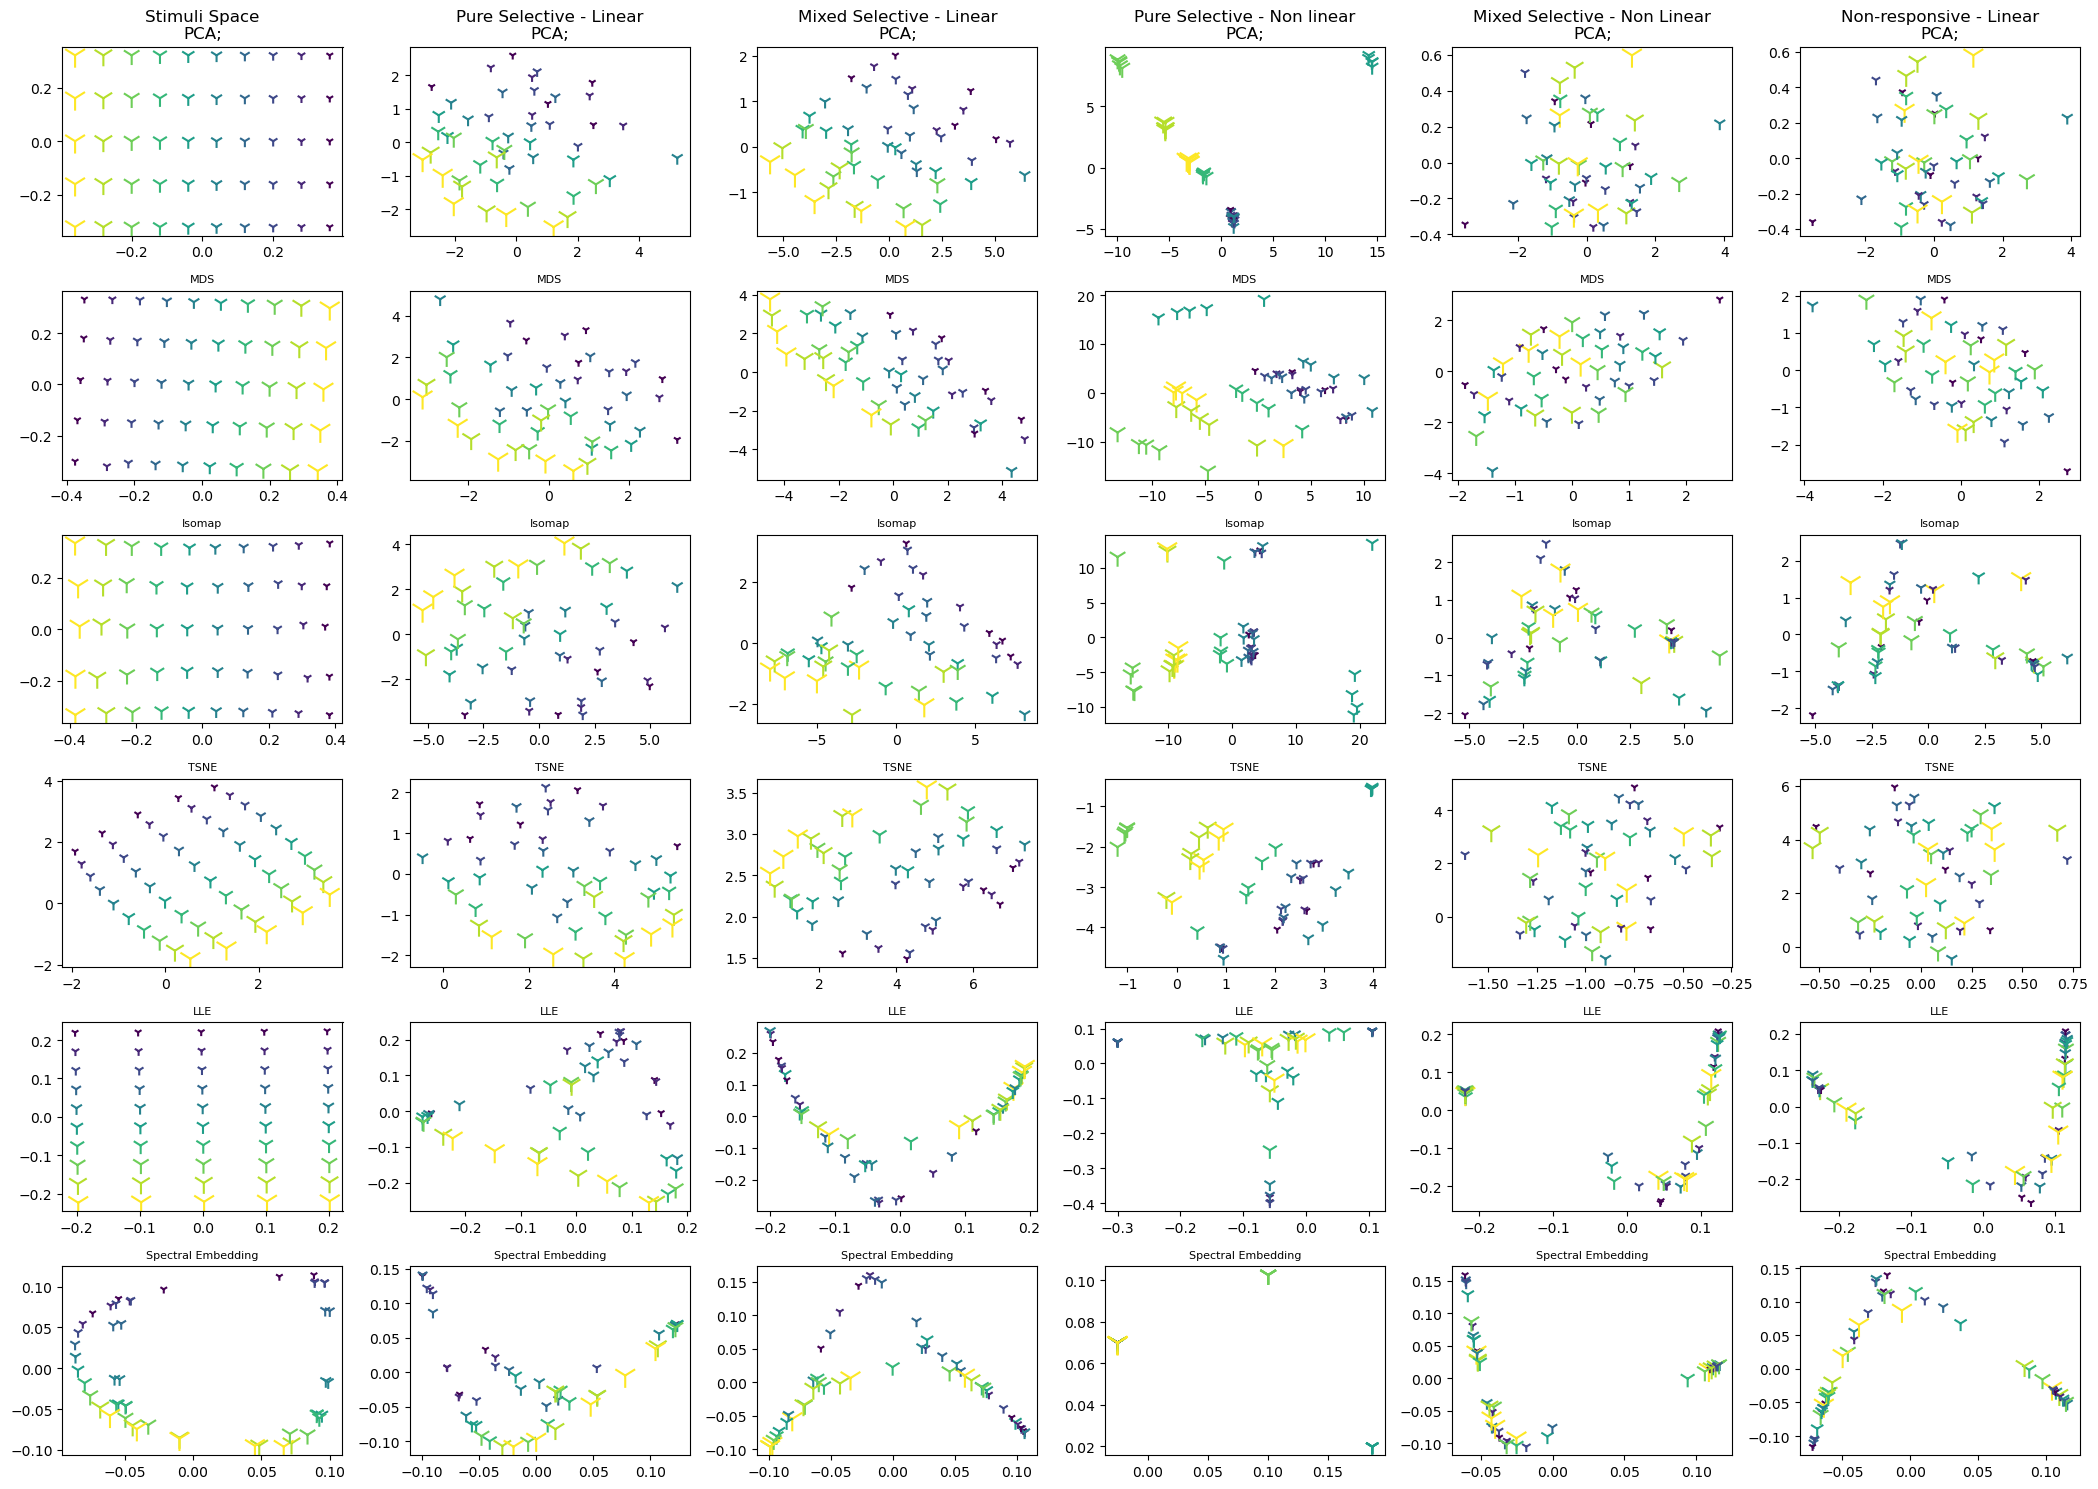

In [12]:
# visualize neural representation - firing response

# compute Dim reduction
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import SpectralEmbedding

# calculate...
pca_space, mds_space, isomap_space, tsne_space, LLE_space, spec_space = {}, {}, {}, {}, {}, {}
for js,(s_name,s_mat) in enumerate(NeuronSpaces.items()):
    pca_space[s_name] = PCA(n_components=2).fit_transform(s_mat)
    mds_space[s_name] = MDS(n_components=2).fit_transform(s_mat)
    isomap_space[s_name] = Isomap(n_components=2, n_neighbors=10).fit_transform(s_mat)
    tsne_space[s_name] = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(s_mat)
    LLE_space[s_name] = LocallyLinearEmbedding(n_components=2).fit_transform(s_mat)
    spec_space[s_name] = SpectralEmbedding(n_components=2).fit_transform(s_mat)

# Plot firing rates and PCA transformed firing rates
cols = len(NeuronSpaces)
rows = 6
fig = plt.figure(figsize=(3.5*cols,15))
for jss,(s_name,s_mat) in enumerate(NeuronSpaces.items()):
    print(s_name, s_mat.shape)
    js=jss+1
    ax1 = fig.add_subplot(6, cols, js)
    ax1.scatter(x=pca_space[s_name][:,0],y=pca_space[s_name][:,1], c=Trees.stimuli[:,1],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax1.set_title(f'{s_name}\nPCA;')

    ax2 = fig.add_subplot(6, cols, cols + js)
    ax2.scatter(x=mds_space[s_name][:,0],y=mds_space[s_name][:,1], c=Trees.stimuli[:,1],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax2.set_title(f'MDS', fontsize=8)

    ax3 = fig.add_subplot(6, cols, 2*cols + js)
    ax3.scatter(x=isomap_space[s_name][:,0],y=isomap_space[s_name][:,1], c=Trees.stimuli[:,1],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax3.set_title(f'Isomap', fontsize=8)

    ax3 = fig.add_subplot(6, cols, 3*cols + js)
    ax3.scatter(x=tsne_space[s_name][:,0],y=tsne_space[s_name][:,1], c=Trees.stimuli[:,1],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax3.set_title(f'TSNE', fontsize=8)

    ax4 = fig.add_subplot(6, cols, 4*cols + js)
    ax4.scatter(x=LLE_space[s_name][:,0],y=LLE_space[s_name][:,1], c=Trees.stimuli[:,1],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax4.set_title(f'LLE', fontsize=8)

    ax5 = fig.add_subplot(6, cols, 5*cols + js)
    ax5.scatter(x=spec_space[s_name][:,0],y=spec_space[s_name][:,1], c=Trees.stimuli[:,1],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax5.set_title(f'Spectral Embedding', fontsize=8)

fig.tight_layout()

## Dimensionality Estimation

In [13]:
import skdim

In [14]:
for js,(s_name,s_mat) in enumerate(NeuronSpaces.items()):
    
    model = PCA(n_components=2)
    model.fit_transform(s_mat)
    dimPC1 =model.explained_variance_ratio_[0]
    dimPCA_default = skdim.id.lPCA().fit(s_mat).dimension_
    dimPCA_PR = round(skdim.id.lPCA(ver='participation_ratio').fit(s_mat).dimension_,2)
    dimFisherS = round(skdim.id.FisherS().fit(s_mat).dimension_,2)
    dimCorrInt = round(skdim.id.CorrInt().fit(s_mat).dimension_,2)
    dimKNN = round(skdim.id.KNN().fit(s_mat).dimension_,2)
    dimMLE= round(skdim.id.MLE().fit(s_mat).dimension_,2)
    dimMiNDML = round(skdim.id.MiND_ML().fit(s_mat).dimension_,2)
    
    
    print(f'{s_name}:\nLINEAR:: PC1 variance = {round(dimPC1,2)}, Participation ratio: {dimPCA_PR}\nNONLINEAR:: Fisher S: {dimFisherS}; CorrInt: {dimCorrInt},KNN: {dimKNN}; MLE: {dimMLE}; MiND_ML: {dimMiNDML}\n')

Stimuli Space:
LINEAR:: PC1 variance = 0.51, Participation ratio: 2.0
NONLINEAR:: Fisher S: 2.1; CorrInt: 1.67,KNN: 2; MLE: 1.96; MiND_ML: 2.16

Pure Selective - Linear:
LINEAR:: PC1 variance = 0.51, Participation ratio: 3.1
NONLINEAR:: Fisher S: 2.08; CorrInt: 3.74,KNN: 8; MLE: 4.73; MiND_ML: 6.85

Mixed Selective - Linear:
LINEAR:: PC1 variance = 0.76, Participation ratio: 1.7
NONLINEAR:: Fisher S: 2.11; CorrInt: 2.61,KNN: 12; MLE: 3.57; MiND_ML: 5.55

Pure Selective - Non linear:
LINEAR:: PC1 variance = 0.35, Participation ratio: 4.53
NONLINEAR:: Fisher S: 2.53; CorrInt: 2.36,KNN: 1; MLE: 2.94; MiND_ML: 2.87

Mixed Selective - Non Linear:
LINEAR:: PC1 variance = 0.53, Participation ratio: 3.53
NONLINEAR:: Fisher S: 0.94; CorrInt: 8.56,KNN: 200; MLE: 10.05; MiND_ML: 10.0

Non-responsive - Linear:
LINEAR:: PC1 variance = 0.52, Participation ratio: 3.56
NONLINEAR:: Fisher S: 0.95; CorrInt: 8.14,KNN: 4; MLE: 10.2; MiND_ML: 10.0



In [15]:
DimensionalityMetrics = ['PC1', 'PCA_default', 'Participation Ratio', 'FisherS', 'CorrInt', 'KNN', 'MLE', 'MiNDML']
dim_dict = {}

for js,(s_name,s_mat) in enumerate(NeuronSpaces.items()):
    # PCA
    model = PCA(n_components=2)
    model.fit_transform(s_mat)
    dimPC1 =model.explained_variance_ratio_[0]
    # intrinsic dimensionality methods
    dimPCA_default = skdim.id.lPCA().fit(s_mat).dimension_
    dimPCA_PR = round(skdim.id.lPCA(ver='participation_ratio').fit(s_mat).dimension_,2)
    dimFisherS = round(skdim.id.FisherS().fit(s_mat).dimension_,2)
    dimCorrInt = round(skdim.id.CorrInt().fit(s_mat).dimension_,2)
    dimKNN = round(skdim.id.KNN().fit(s_mat).dimension_,2)
    dimMLE= round(skdim.id.MLE().fit(s_mat).dimension_,2)
    dimMiNDML = round(skdim.id.MiND_ML().fit(s_mat).dimension_,2)
    
    dim_dict[s_name] = [dimPC1, dimPCA_default, dimPCA_PR, dimFisherS, dimCorrInt, dimKNN, dimMLE, dimMiNDML]

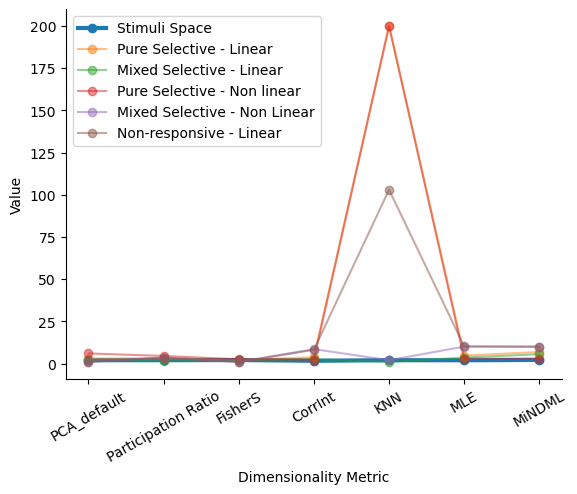

In [16]:
for s_name in dim_dict:
    if s_name == 'Stimuli Space':
        plt.plot(dim_dict[s_name][1:], linewidth = 3, marker = 'o', label = s_name)
    else:
        plt.plot(dim_dict[s_name][1:], alpha=0.5, marker = 'o', label = s_name)
plt.xticks(ticks=np.arange(len(dim_dict[s_name][1:])), labels=DimensionalityMetrics[1:], rotation=30)
plt.xlabel('Dimensionality Metric')
plt.ylabel('Value')
    
plt.legend()
sns.despine()

# Hypothesis-Driven Approach

## RSA

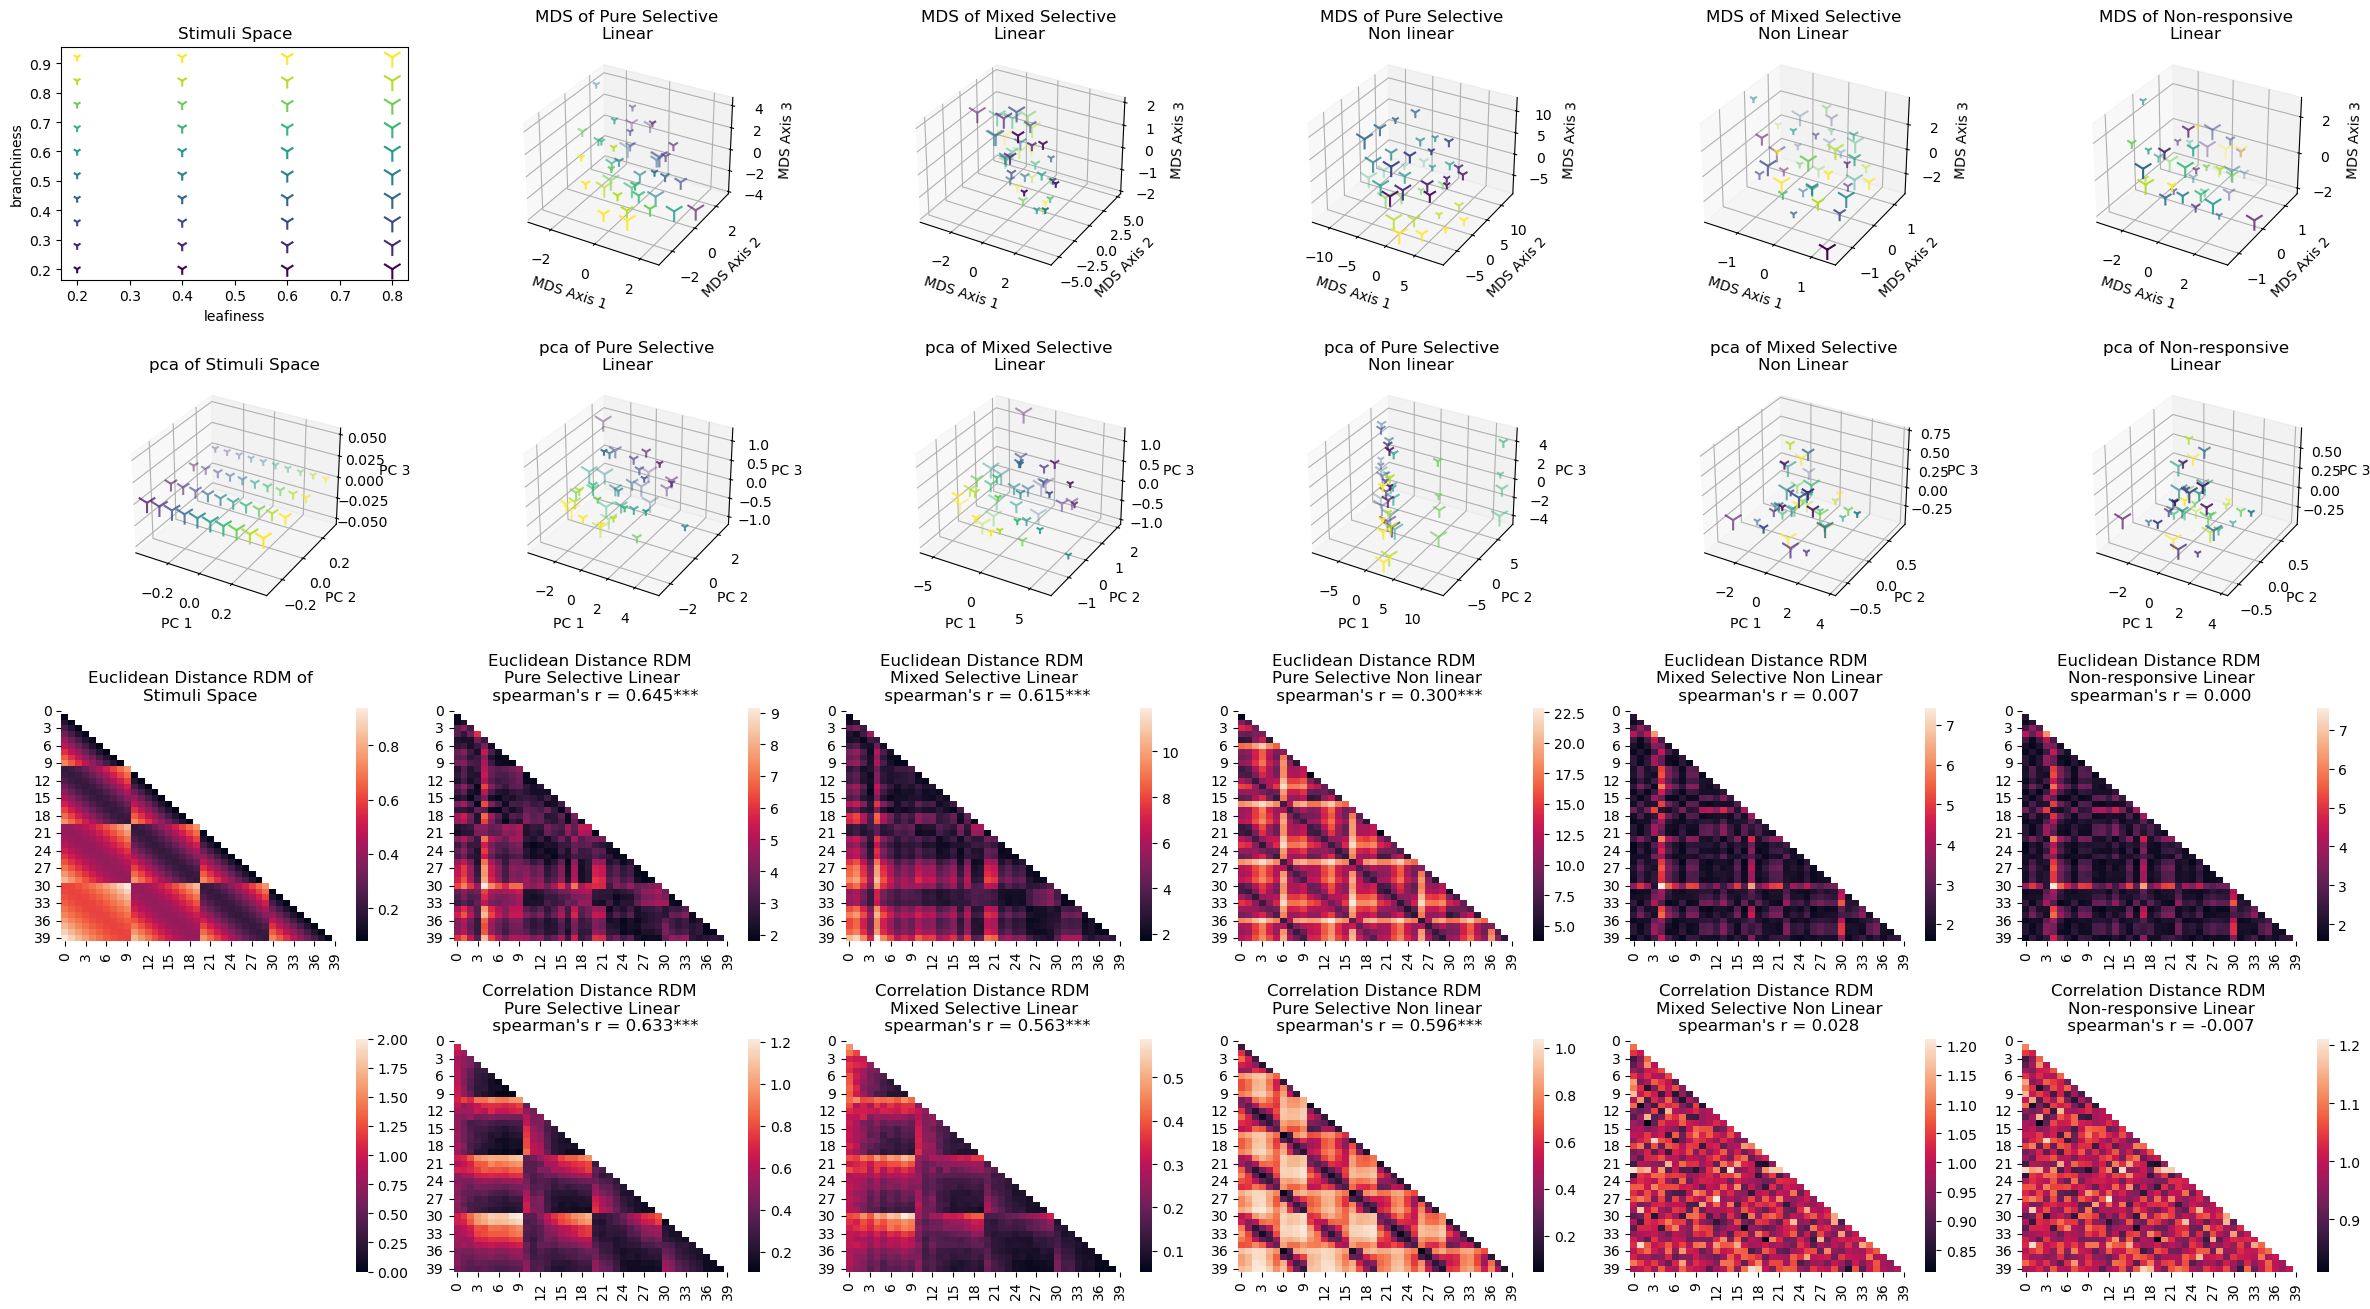

In [15]:
n_compo = 3
pca_sapce,mds_space = {},{}
for js,(s_name,s_mat) in enumerate(NeuronSpaces.items()):
    if "Stimuli" in s_name and n_compo==3:
        pca_sapce |= {s_name:np.concatenate([PCA(n_components=2).fit_transform(s_mat),np.zeros((Trees.stimuli.shape[0],1))],axis=1)}
        mds_res = MDS(n_components=2,normalized_stress="auto",dissimilarity="precomputed").fit_transform(compute_rdm(s_mat,"euclidean"))
        mds_space |= {s_name:np.concatenate([mds_res,np.zeros((Trees.stimuli.shape[0],1))],axis=1)}        
    else:
        pca_sapce |= {s_name:PCA(n_components=n_compo).fit_transform(s_mat)}
        mds_res = MDS(n_components=n_compo,normalized_stress="auto",dissimilarity="precomputed").fit_transform(compute_rdm(s_mat,"euclidean"))
        mds_space |= {s_name:mds_res}

plt_rows,plt_cols = 4,len(NeuronSpaces)
fig_fspace,ax_fspace = plt.subplots(plt_rows,plt_cols,
                                    figsize=(4*plt_cols,3.3*plt_rows))
for js,((s_name,s_mat),pca_res,mds_res) in enumerate(zip(NeuronSpaces.items(),pca_sapce.values(),mds_space.values())):
    if "Stimuli" in s_name:
        ax_fspace[0,js].scatter(x=s_mat[:,0],y=s_mat[:,1],c=stim_space[:,1],s=np.exp(stim_space[:,0]*3+3),marker="1")
        ax_fspace[0,js].set_title(s_name.replace(' - ','\n'))
        ax_fspace[0,js].set_xlabel(Trees.featurenames[0])
        ax_fspace[0,js].set_ylabel(Trees.featurenames[1])
    else:
        if n_compo == 3:
            ax_fspace[0,js].remove()
            ax_fspace[0,js]=fig_fspace.add_subplot(plt_rows,plt_cols,js+1,projection='3d')
            ax_fspace[0,js].scatter(mds_res[:,0],mds_res[:,1],mds_res[:,2],c=stim_space[:,1],s=np.exp(stim_space[:,0]*3+3),marker="1")   
            ax_fspace[0,js].set_zlabel("MDS Axis 3")         
        else:
            ax_fspace[0,js].scatter(mds_res[:,0],mds_res[:,1],c=stim_space[:,1],s=np.exp(stim_space[:,0]*3+3),marker="1")
        ax_fspace[0,js].set_title('MDS of '+s_name.replace(' - ','\n'))
        ax_fspace[0,js].set_xlabel("MDS Axis 1")
        ax_fspace[0,js].set_ylabel("MDS Axis 2")
    
    if n_compo == 3:
        ax_fspace[1,js].remove()
        ax_fspace[1,js]=fig_fspace.add_subplot(plt_rows,plt_cols,1*plt_cols+js+1,projection='3d')
        ax_fspace[1,js].scatter(pca_res[:,0],pca_res[:,1],pca_res[:,2],c=stim_space[:,1],s=np.exp(stim_space[:,0]*3+3),marker="1")
        ax_fspace[1,js].set_zlabel("PC 3")
    else:
        ax_fspace[1,js].scatter(x=pca_res[:,0],y=pca_res[:,1],c=stim_space[:,1],s=np.exp(stim_space[:,0]*3+3),marker="1")
    ax_fspace[1,js].set_title('pca of '+s_name.replace(' - ','\n'))
    ax_fspace[1,js].set_xlabel("PC 1")
    ax_fspace[1,js].set_ylabel("PC 2")
    
    model_rdm = compute_rdm(stim_space,"euclidean")
    euc_rdm = compute_rdm(s_mat,"euclidean")
    euc_rdm[np.triu_indices(euc_rdm.shape[0])]=np.nan
    sns.heatmap(euc_rdm,ax=ax_fspace[2,js])
    corr_rdm = compute_rdm(s_mat,"correlation")
    corr_rdm[np.triu_indices(corr_rdm.shape[0])]=np.nan
    sns.heatmap(corr_rdm,ax=ax_fspace[3,js])
    if "Stimuli" in s_name:
        ax_fspace[2,js].set_title('Euclidean Distance RDM of\n'+s_name.replace(' - ',' '))
        #ax_fspace[3,js].set_title('Correlation Distance RDM of\n'+s_name.replace(' - ',' '))
        ax_fspace[3,js].remove()
    else:
        r_e = scipy.stats.spearmanr(lower_tri(model_rdm)[0],lower_tri(euc_rdm)[0])
        p_sigif = np.array([" ","*","**","***"])[[r_e.pvalue>=0.05,r_e.pvalue<0.05 and r_e.pvalue>=0.01, r_e.pvalue<0.01 and r_e.pvalue>=0.001,r_e.pvalue<0.001]][0]
        rsa_res = f"\n spearman's r = {r_e.statistic:.3f}{p_sigif}"
        ax_fspace[2,js].set_title('Euclidean Distance RDM \n'+s_name.replace(' - ',' ')+rsa_res)
        
        r_c = scipy.stats.spearmanr(lower_tri(model_rdm)[0],lower_tri(corr_rdm)[0])
        p_sigif = np.array([" ","*","**","***"])[[r_c.pvalue>=0.05,r_c.pvalue<0.05 and r_c.pvalue>=0.01, r_c.pvalue<0.01 and r_c.pvalue>=0.001,r_c.pvalue<0.001]][0]
        rsa_res = f"\n spearman's r = {r_c.statistic:.3f}{p_sigif}"
        ax_fspace[3,js].set_title('Correlation Distance RDM \n'+s_name.replace(' - ',' ')+rsa_res)  
    
fig_fspace.tight_layout()

## Decoding

### CCGP

In [ ]:
stim_space = deepcopy(Trees.stimuli)
randsplit_branchiness = np.concatenate([np.zeros(int(Trees.features[1].size/2)),np.ones(int(Trees.features[1].size/2))])
randsplit_branchiness = np.random.permutation(randsplit_branchiness)
branchiness = stim_space[:,1]
np.atleast_2d([randsplit_branchiness[np.where(Trees.features[1] == x)][0] for x in branchiness])
cv_stimspace = np.concatenate([np.atleast_2d([randsplit_branchiness[np.where(Trees.features[1] == x)][0] for x in branchiness]).T,
                               stim_space[:,[0]]],axis=1)
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

predict_var = 1
print(f"predict {Trees.featurenames[predict_var]} feature with {np.unique(stim_space[:,predict_var]).size} unique values, cross {Trees.featurenames[int(1-predict_var)]} condition generalization")
ave_score = []
for js,(s_name,s_mat) in enumerate(NeuronSpaces.items()):
    X = s_mat# scale_feature(s_mat,2)#PCA(n_components=0.9).fit_transform(s_mat)
    y = stim_space[:,predict_var]
    groups = cv_stimspace[:,predict_var]
    print(f"\n {s_name}")
    fit_score = {
             #"Linear Regression": [],
             "kernel regression linear no l2": [],
             #"kernel regression linear": [],
             "kernel regression": [],
             "MeanDummy Regressor": []}
    eval_score = {
             #"Linear Regression": [],
             "kernel regression linear no l2": [],
             #"kernel regression linear": [],
             "kernel regression": [],
             "MeanDummy Regressor": []}
    for j,(fit_idx,eval_idx) in enumerate(logo.split(X=X,groups=groups)):
        assert np.unique(y[fit_idx]).size == np.unique(stim_space[:,predict_var]).size    
        estimators = {
                #"Linear Regression": LinearRegression(),
                "kernel regression linear no l2": KernelRidge(alpha=0,kernel="linear"),
                #"kernel regression linear": KernelRidge(alpha=1.0,kernel="linear"),
                "kernel regression": KernelRidge(alpha=0,kernel="rbf"),
                "MeanDummy Regressor": DummyRegressor(strategy="mean")
            }
        for k in estimators.keys():
            estimators[k].fit(X[fit_idx,:], y[fit_idx])
            sf = estimators[k].score(X[fit_idx,:], y[fit_idx])
            se = estimators[k].score(X[eval_idx,:], y[eval_idx])
            fit_score[k].append(sf)
            eval_score[k].append(se)
            
    ave_score.append(pd.DataFrame({"decoder":estimators.keys(),
                                   "fit score": [np.mean(v) for v in fit_score.values()],
                                   "evaluation score": [np.mean(v) for v in eval_score.values()]}
                                 ).assign(ensemble=s_name)
                     )
    ave_score_str = [f"{k} {np.mean(v):0.3f}" for k,v in eval_score.items()]
    print(f"mean evaluation score:"+ '; '.join(ave_score_str))

In [ ]:
ave_score_df = pd.melt(pd.concat(ave_score,axis=0),
                       id_vars=["decoder","ensemble"],
                       value_name="score",
                       var_name="stage")
decoder_gs = sns.catplot(ave_score_df,x="stage",y="score",hue="ensemble",col="decoder",dodge=True,sharey=False)
[plt.setp(ax.get_xticklabels(),rotation=25,ha="right") for ax in decoder_gs.axes.flatten()]